In [1]:
from dataset_nuscenes import DepthDatasetNuscenes
from model import RadarCamModel
from loss import custom_loss, depth_loss
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import datetime
from plotting import draw_result, draw_error_map
import json
import sys
import copy
import os

%matplotlib inline

# DATASET PARAMETERS
DIR_DATA = '/ssd/Datasets_and_code/nuscenes_depth_estimation/dataset/dataset_radar_cam' # Root to the folder with the prepared data
W_RESIZED = 800 #800 # If 0, the image is not resized in width
H_RESIZED = 450 #450 # If 0, the image is not resized in height
MIN_DIST = 0.0 # Threshold minimum depth to discard points
MAX_DIST = 50.0 # Threshold maximum depth to discard points
NUMBER_RADAR_POINTS = 100 # Number of radar points to use. If the number of points in a sample is less than this, they are 
                          # resampled randomly to create an array of fixed number of points. This shouldn't hurt the performance
AUGMENT_DIST = False # If True, data augmentation is performed to increase the diversity of data. We can augment in two ways:
AUGMENT_DIST_MAX_SUBTRACT = 5.0 # Subtracts a random number to all the points of the pointcloud between 0 and AUGMENT_DIST_MAX_SUBTRACT
AUGMENT_DIST_MIN_SCALE = 0.5 # Scales the distance of all points of the pointcloud with a random number between AUGMENT_DIST_MIN_SCALE and 1
    
# MODEL PARAMETERS
BATCH_SIZE = 32
RADAR_CHANNELS_ENCODER = [64, 128, 256, 432] 
UNET_CHANNELS_IMG = [2, 4, 8, 12, 16, 24, 32, 48] 
UNET_CHANNELS_RADAR = 24

# TRAINING PARAMETERS
L2_LIDAR = False
ALPHA_LOSS = 1.0
BETA_LOSS = 5.0
GAMMA_LOSS = 0.0
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
NUMBER_SAMPLES_PLOT = 3
LOAD_MODEL = False
MODEL_PATH = 'results/2024-05-22_22-49-26/model_14.pth'

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

train_set = DepthDatasetNuscenes("train", DIR_DATA, W_RESIZED, H_RESIZED, MIN_DIST, MAX_DIST, NUMBER_RADAR_POINTS, 
                                 AUGMENT_DIST, AUGMENT_DIST_MAX_SUBTRACT, AUGMENT_DIST_MIN_SCALE)
train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)

val_set = DepthDatasetNuscenes("val", DIR_DATA, W_RESIZED, H_RESIZED, MIN_DIST, MAX_DIST, NUMBER_RADAR_POINTS)
val_dataloader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle=True)

model = RadarCamModel(RADAR_CHANNELS_ENCODER, UNET_CHANNELS_IMG, UNET_CHANNELS_RADAR).to(device)
model.required_radar_size(torch.from_numpy(np.expand_dims(train_set.__getitem__(0)[1], axis=0)).to(device, dtype=torch.float))
n_params = sum([p.numel() for p in model.parameters()])
n_params_radar = sum([p.numel() for p in model.radar_encoder.parameters()])
n_params_unet = sum([p.numel() for p in model.unet.parameters()])

if LOAD_MODEL:
    model.load_state_dict(torch.load(MODEL_PATH))
    print("Model successfully loaded!")

print("Total number of parameters: ", n_params)
print("UNet number of parameters: ", n_params_unet)
print("Radar number of parameters: ", n_params_radar)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define variables to track the best validation loss and corresponding model parameters
val_losses = []
model_params = []

Using device:  cuda
The required radar size is: (batch, 432)
Total number of parameters:  288443
UNet number of parameters:  134923
Radar number of parameters:  153520


  9%|████                                        | 1/11 [00:03<00:33,  3.36s/it]

Loss lidar: 0.41219478845596313, loss smoothness: 0.06599129736423492, loss consistency: 0.0
Epoch 1, batch 0, Loss: 0.7421512603759766


  0%|                                                     | 0/2 [00:00<?, ?it/s]

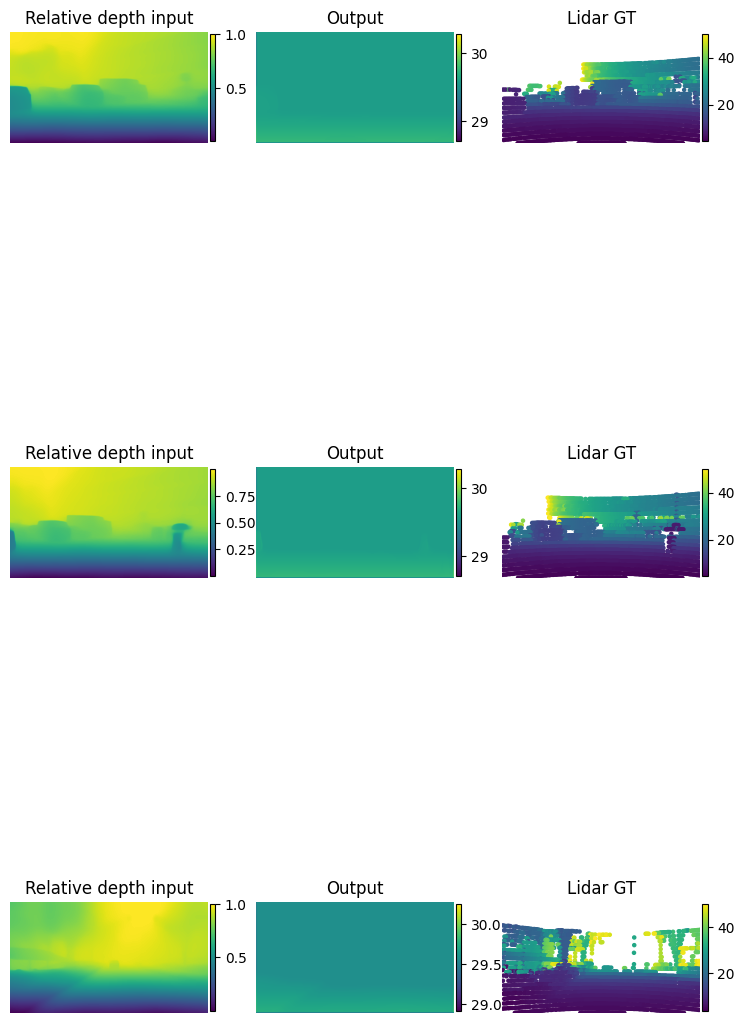

100%|█████████████████████████████████████████████| 2/2 [00:33<00:00, 16.65s/it]


Epoch 1/2, Train Loss: 0.5103860009800304, val loss NN total: 0.3115968108177185, val loss NN lidar: 0.3039575666189194,  val loss NN smoothness: 0.001527847838588059, val loss NN consistency: 0.0


  9%|████                                        | 1/11 [00:01<00:15,  1.55s/it]

Loss lidar: 0.3394371569156647, loss smoothness: 0.00905061885714531, loss consistency: 0.0
Epoch 2, batch 0, Loss: 0.3846902549266815


  0%|                                                     | 0/2 [00:00<?, ?it/s]

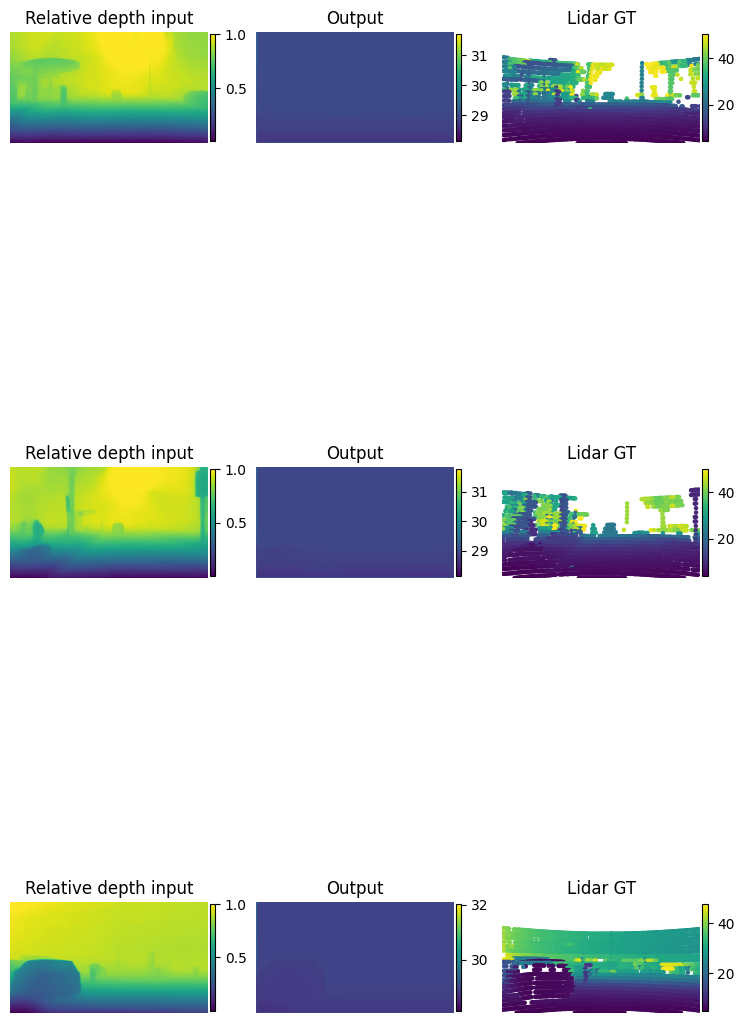

100%|█████████████████████████████████████████████| 2/2 [00:33<00:00, 16.57s/it]

Epoch 2/2, Train Loss: 0.35838453607125714, val loss NN total: 0.30526603758335114, val loss NN lidar: 0.29984231293201447,  val loss NN smoothness: 0.0010847451630979776, val loss NN consistency: 0.0
Training finished.


In [2]:
for epoch in range(NUM_EPOCHS):
    ##################### TRAIN #######################
    model.train()
    train_loss = 0.0
    
    for batch_idx, (sample_token, rel_depth, radar, lidar) in enumerate(tqdm(train_dataloader)):
        rel_depth, radar, lidar = rel_depth.to(device, dtype=torch.float), radar.to(device, dtype=torch.float), lidar.to(device, dtype=torch.float)
           
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(rel_depth, radar)
        
        # Calculate loss
        loss = custom_loss(output, lidar, rel_depth, l2_lidar=L2_LIDAR, alpha=ALPHA_LOSS, beta=BETA_LOSS, gamma=GAMMA_LOSS)
        
        # Backward pass
        loss[0].backward()
        
        # Optimize
        optimizer.step()
        
        train_loss += loss[0].item()

        if (batch_idx % 50 == 0):
            print(f"Loss lidar: {loss[1]}, loss smoothness: {loss[2]}, loss consistency: {loss[3]}")
            print(f"Epoch {epoch+1}, batch {batch_idx}, Loss: {train_loss/(batch_idx+1)}")

    train_loss /= float(batch_idx+1)
     
        
    ##################### VALIDATION #######################
    model.eval()
    val_loss = 0.0
    val_loss_lidar = 0.0
    val_loss_smoothness = 0.0
    val_loss_consistency = 0.0

    
    with torch.no_grad():
        for batch_idx, (sample_token, rel_depth, radar, lidar) in enumerate(tqdm(val_dataloader)):
            rel_depth, radar, lidar = rel_depth.to(device, dtype=torch.float), radar.to(device, dtype=torch.float), lidar.to(device, dtype=torch.float)

            output = model(rel_depth, radar)
            
            loss = custom_loss(output, lidar, rel_depth, l2_lidar=L2_LIDAR, alpha=ALPHA_LOSS, beta=BETA_LOSS, gamma=GAMMA_LOSS)
            val_loss += loss[0].item()
            val_loss_lidar += loss[1].item()
            val_loss_smoothness += loss[2].item()
            val_loss_consistency += loss[3].item()
            
            if (batch_idx==0):
                rel_depth_sample = rel_depth.cpu()[:NUMBER_SAMPLES_PLOT,:, :, :]
                lidar_sample = lidar.cpu()[:NUMBER_SAMPLES_PLOT,:, :, :]
                output_sample = output.cpu()[:NUMBER_SAMPLES_PLOT,:, :, :]
                draw_result(rel_depth_sample, output_sample, lidar_sample, MIN_DIST, MAX_DIST)

        val_loss /= float(batch_idx+1)
        val_loss_lidar /= float(batch_idx+1)
        val_loss_smoothness /= float(batch_idx+1)
        val_loss_consistency /= float(batch_idx+1)
    
    # Print average loss at the end of each epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss}, val loss NN total: {val_loss}, val loss NN lidar: {val_loss_lidar},  val loss NN smoothness: {val_loss_smoothness}, val loss NN consistency: {val_loss_consistency}")
    
    val_losses.append(val_loss)
    model_params.append(copy.deepcopy(model.state_dict()))

print("Training finished.")

In [3]:
# Define the file path where you want to save the model
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder_path = f"results/{current_date}"
os.mkdir(folder_path) 
json_path = os.path.join(folder_path,"params.json")

json_params = { 
    "W_RESIZED" : W_RESIZED, 
    "H_RESIZED" : H_RESIZED, 
    "MIN_DIST" : MIN_DIST, 
    "MAX_DIST" : MAX_DIST,
    "NUMBER_RADAR_POINTS" : NUMBER_RADAR_POINTS,
    "RADAR_CHANNELS_ENCODER" : RADAR_CHANNELS_ENCODER,
    "UNET_CHANNELS_IMG" : UNET_CHANNELS_IMG,
    "UNET_CHANNELS_RADAR" : UNET_CHANNELS_RADAR,
    "L2_LIDAR" : L2_LIDAR,
    "ALPHA_LOSS" : ALPHA_LOSS,
    "BETA_LOSS" : BETA_LOSS,
    "GAMMA_LOSS" : GAMMA_LOSS,
    "LEARNING_RATE" : LEARNING_RATE,
    "LOAD_MODEL" : LOAD_MODEL,
    "MODEL_PATH" : MODEL_PATH,
    "val_losses" : val_losses
} 

# Save the model state dictionary
# Finding inimum
min_error = min(val_losses)
 
# iterating over the list like index,
# item pair
print(val_losses)
for i in range(len(model_params)):
    model_path = os.path.join(folder_path,f"model_{i}.pth")
    torch.save(model_params[i], model_path)
        
with open(json_path, "w") as outfile: 
    json.dump(json_params, outfile)

print(f"Model saved to {folder_path}")

[0.3115968108177185, 0.30526603758335114]
Model saved to results/2024-06-07_14-24-42
